In [2]:
import cv2
import matplotlib.pyplot as plt

In [3]:
def show_image(image, title="Image", cmap_type="gray"):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [7]:
def count_grains(path):
    # Load the image
    image = cv2.imread(path)

    # Convert to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply binary thresholding (inverse binary)
    _, binary = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY_INV)

    # Apply morphological operations to remove small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    cleaned_binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Display the cleaned binary image
    show_image(cleaned_binary, "Cleaned Binary Image (After Morphological Operations)")

    # Re-detect contours on the cleaned binary image
    contours, _ = cv2.findContours(cleaned_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area to remove noise
    min_contour_area = 50  # Minimum contour area to consider
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    print(f"Number of filtered contours: {len(filtered_contours)}")

    # Analyze filtered contours
    grain_shortest_lengths = []
    for contour in filtered_contours:
        if len(contour) >= 5:  # Minimum points needed for ellipse fitting
            ellipse = cv2.fitEllipse(contour)
            _, (major_axis, minor_axis), _ = ellipse
            grain_shortest_lengths.append(minor_axis)

    if not grain_shortest_lengths:
        print("No valid grains detected after filtering contours.")
        return 0

    # Calibration factor (e.g., mm per pixel)
    calibration_factor = 0.0039016750486215255
    grain_lengths_real = [length * calibration_factor for length in grain_shortest_lengths]
    if not grain_lengths_real:
        print("No grains detected after applying calibration.")
        return 0

    # Calculate average grain length
    average_length_mm = sum(grain_lengths_real) / len(grain_lengths_real)
    print("Average shortest length (millimeters):", average_length_mm)
    return average_length_mm


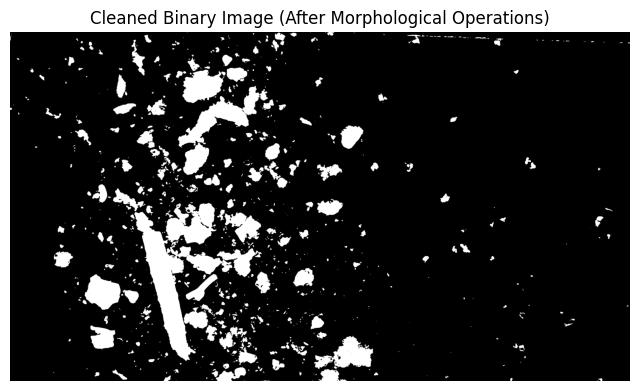

Number of filtered contours: 386
Average shortest length (millimeters): 0.17231205751266251


0.17231205751266251

In [10]:
count_grains("data/233801-240125052635.jpg")